In [1]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = True

In [2]:
# Initializing matrix
num_nodes = 1000
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

# define targets
time_points = np.arange(3000)
targets = ((np.sin((time_points+1)/60*np.pi))/4 + 0.5)

In [6]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 250
inh_weight_sum = 250
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [7]:
# define output params
gainout= 1.15
shiftout= -2.5
# gainout= 1.3
# shiftout= -0.9
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [8]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    # if u is the shift modulation    
    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor + u_tensor - self.shift_tensor))
        return y_tensor

    # # if u and r all applied on activation    
    # def f_tensor(self, x_tensor, u_tensor, r_tensor):
    #     y_tensor = (1 - self.c) * x_tensor \
    #         + self.c * self.activation_func((self.gain_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) - self.shift_tensor)) \
    #         + self.c * (r_tensor + u_tensor)
    #     return y_tensor
         
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    # def jacob(self, x, u, r):
    #     x_tensor = tensor(x)
    #     u_tensor = tensor(u)
    #     r_tensor = tensor(r)
    #     dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
    #     Jx_tensor = dydx.squeeze(dim=(1,3))
    #     Ju_tensor = dydu.squeeze(dim=(1,3))
    #     Jr_tensor = dydr.squeeze(dim=(1,3))
    #     Jx = Jx_tensor.numpy()
    #     Ju = Ju_tensor.numpy()
    #     Jr = Jr_tensor.numpy()
    #     return Jx, Ju, Jr

    def f_linear(self, x, u, r):  # assume gain == 1 and shirt == 0
        y = (1 - self.c) * x \
            + self.c * (0.5 + 0.25 * self.g * self.weight_matrix @ x) \
            + self.c * (r + u)
        return y

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

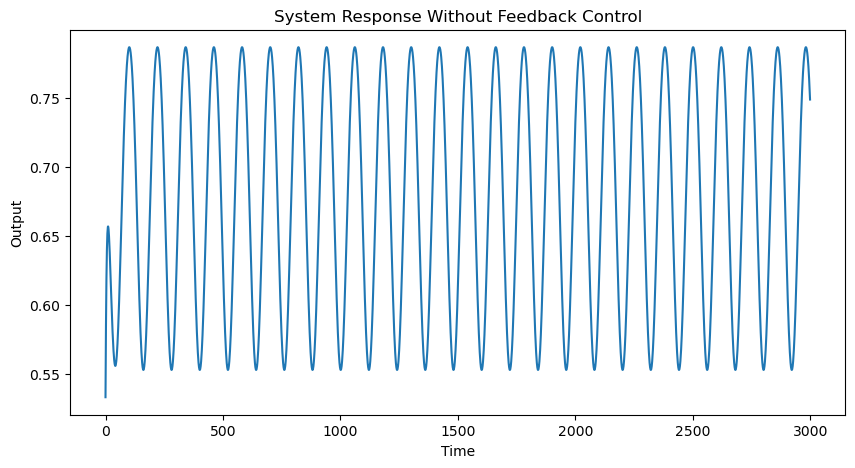

In [9]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs = []
outputs_ff = []

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))  # previously wrong!

    # input
    this_input = targets[i]  # input t, output t+1
    r = feedback_weight_matrix @ np.array([[this_input]])
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    # x1 = jnn.f_linear(x, u, r)
    # F, G, R = jnn_ff.jacob(x, u, r)
    # x1 = F @ x + G @ u + R @ r
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

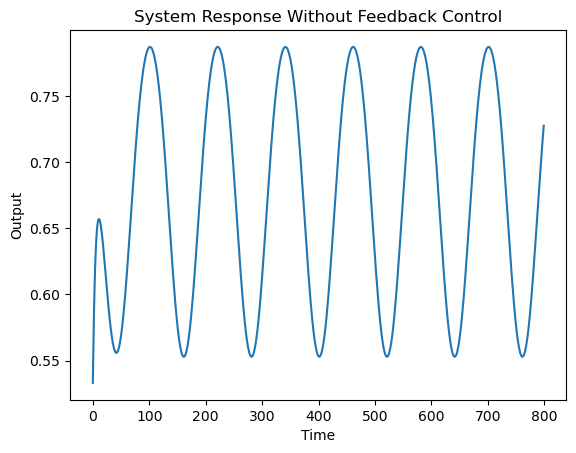

In [11]:
# Plot the output
plt.plot(time_points[0:800], outputs_ff[0:800])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_outputs.png")

Text(0.5, 0, 'Time point')

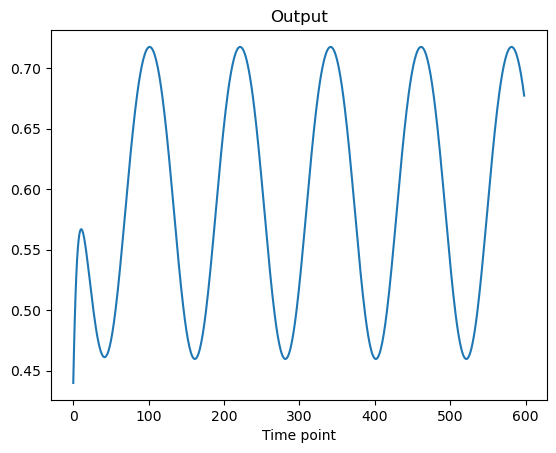

In [133]:
network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=shiftout, gainout=gainout, target=targets)
states, activations, outputs = network.simulate(60)

plt.plot(outputs)
plt.title("Output")
plt.xlabel("Time point")

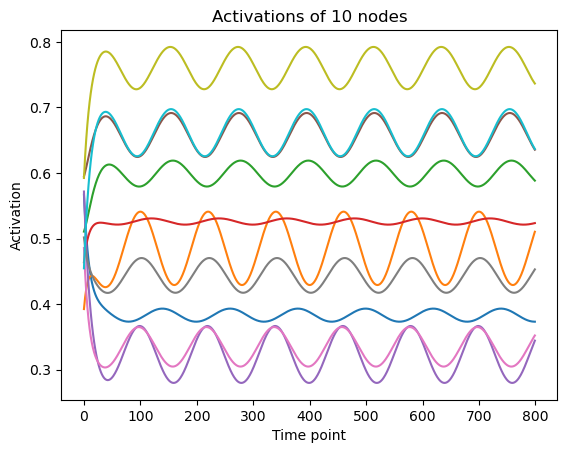

In [134]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10, 20):
    plt.plot(all_xs[i,0: 800], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_activations.png")

### Hebbian Learning for Phase Correction

In [135]:
# from scipy.fft import fft, fftfreq

# def get_period_and_phase(y):

#     # Perform the Fast Fourier Transform (FFT)
#     y_mean = np.mean(y)
#     y_fft = fft(y-y_mean)

#     # Get the sample frequencies
#     sample_freq = fftfreq(time_points.size, d=time_points[1] - time_points[0])

#     # Find the index of the peak in the Fourier Transform magnitude
#     index_peak = np.argmax(np.abs(y_fft))

#     # Get the dominant frequency
#     dominant_freq = sample_freq[index_peak]

#     # Calculate the period of the signal
#     period = 1 / dominant_freq

#     # Extract the phase of the dominant frequency
#     phase_extracted = np.angle(y_fft[index_peak])

#     # print(f"Dominant Frequency: {dominant_freq} Hz")
#     # print(f"Period: {period}")
#     # print(f"Extracted Phase: {phase_extracted} radians")

#     return period, phase_extracted

# # extrach all phases in all_xs
# phases = []
# for i in range(num_nodes):
#     y = all_xs[i]
#     period, phase_extracted = get_period_and_phase(y)
#     phases.append(phase_extracted)

# phases

In [136]:
# define targets
time_points = np.arange(6000)
# inputs = ((np.sin((time_points)/60*np.pi))/4 + 0.5)
targets = ((np.sin((time_points + 20)/60*np.pi))/4 + 0.5)

# inputs with different phases
np.random.seed(2)
inputs = []
for i in range(num_nodes):
    this_input = (np.sin((time_points + np.random.randint(0, 120))/60*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

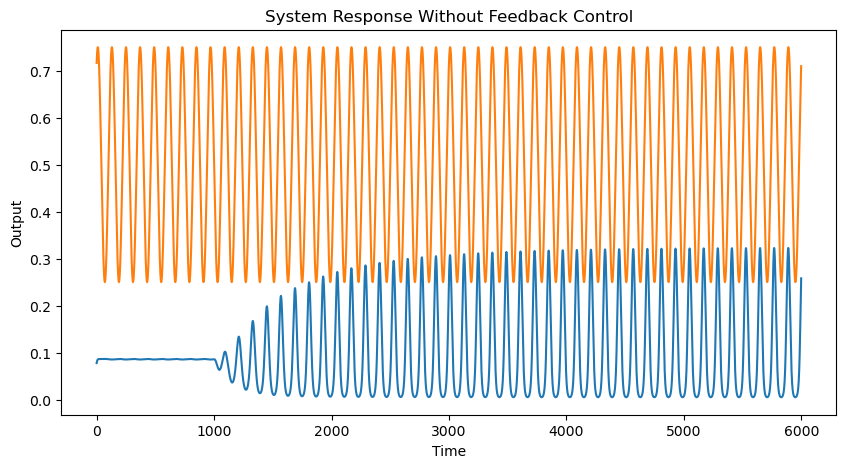

In [137]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs = []
weights = []
outputs_ff = []
has_hebbian = False
# gainout= 1.48  # for f_linear
# shiftout= -0.26
# gainout= 1.45  # for f
# shiftout= -0.16
gainout = 0.2
shiftout = 10
hebbian_lr = 0.01

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and i > 1000:
        has_hebbian = True
        x_mean = np.concatenate(xs, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs, axis=1).std(axis=1).reshape(-1, 1)
        target_mean = 0.5
    if has_hebbian:
        this_target = targets[i]
        # Calculate Hebbian weight updates
        hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    # this_input = targets[i]
    # this_input = inputs[i]
    # r = feedback_weight_matrix @ np.array([[this_input]])
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    # x1 = jnn_ff.f_linear(x, u, r)
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()

    # save
    xs.append(x)
    weights.append(this_output_weight_matrix.copy())
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

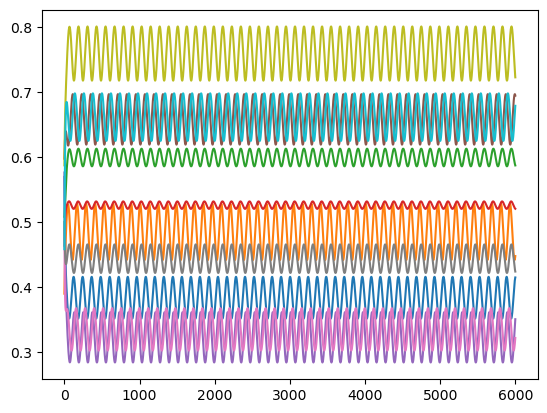

In [138]:
all_xs = np.concatenate(xs, axis=1)
for i in range(10, 20):
    plt.plot(all_xs[i,:], label=f"Node {i}")

In [139]:
peaks = []
for i in range(num_nodes):
    y = all_xs[i]
    p = np.argmax(y[500:620])
    peaks.append(p)
target_peak = np.argmax(targets[500:620])
relative_peaks = np.array(peaks) - target_peak

# plus 120 for relative peaks less than 0
relative_peaks[relative_peaks < 0] += 120
relative_peaks

array([ 33,  13,  37,  13,  67,  39,  68,   8, 115,  83, 113,  38,  56,
        52,   2, 101,  25,  56,  57,   9,  31,  51,  45,  21, 104,  84,
        45,  32,  92, 103,  51, 117,  58,  31,  20,  21, 118,  33, 103,
        59,  54,   3, 116,  81,   9,  26,  98,  10,  38,  86,  60,  26,
         3,  34,  48,  97,  12, 100,  42,  72,  54,  99,  84,  91,  72,
         4,  31,  13,  32,  51,  38,  61,  25,  65,  93, 106, 117,  62,
        57,  21, 109,  79, 105, 113,  96,  83,  32, 107,  77, 117,  85,
        70, 102,   9,  87,  23,  51,  53,  94,  78,  49, 113,  30,  65,
        59,  63,  66,  47,  96,  45,  73, 115,  59, 119,  91, 108,  10,
        27, 113,  22, 103,  61,  79, 114,  80,  72,  52,  29,  78,  19,
         1,   1,  61, 119,  73,  25,  35,  67,  36,   5,  94,  38, 111,
         6,  25,  83, 110,  34,  93,  58, 112,  87,   8,  98,  86,  76,
        82, 104,  73,  28,  11,   1, 115, 110,  98,  30,  48,  99,  44,
        33,   8,  25,  13, 114,  99,  59, 113,  32,   9,  63, 10

In [140]:
target_peak = np.argmax(targets[500:620])
np.argmax(outputs_ff[500:620]) - target_peak

-58

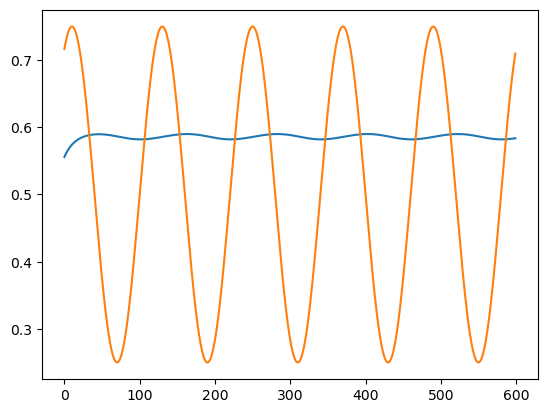

In [141]:
y = all_xs[0]
plt.plot(y[0:600])
plt.plot(targets[0:600])

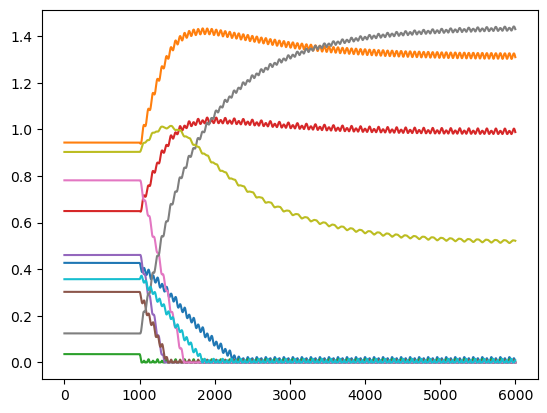

In [142]:
all_weights = np.concatenate(weights, axis=0).T
for i in range(0, 10):
    plt.plot(all_weights[i,:], label=f"Node {i}")

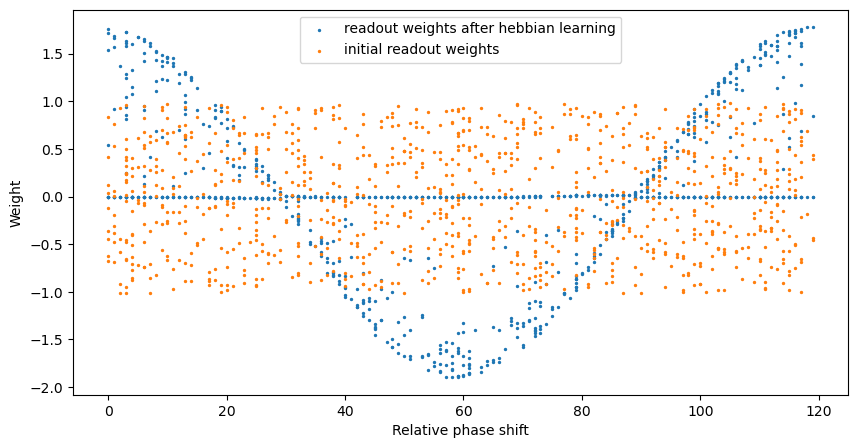

In [143]:
plt.subplots(figsize=(10, 5))
plt.scatter(relative_peaks, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(relative_peaks, output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Relative phase shift")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_phase_outweights.png")

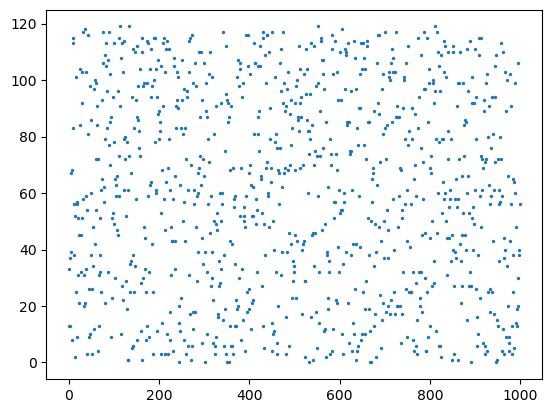

In [144]:
plt.scatter(np.arange(num_nodes), relative_peaks, s=2)

In [145]:
this_output_weight_matrix = this_output_weight_matrix / x_mean.T / 100

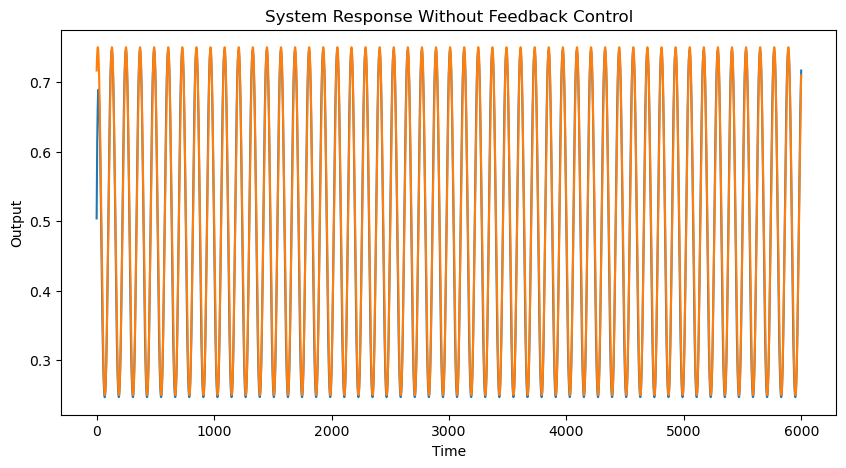

In [146]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs = []
outputs_ff = []
gainout = 4.4
shiftout = 0

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))  # previously wrong!

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    # x1 = jnn.f_linear(x, u, r)
    # F, G, R = jnn_ff.jacob(x, u, r)
    # x1 = F @ x + G @ u + R @ r
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

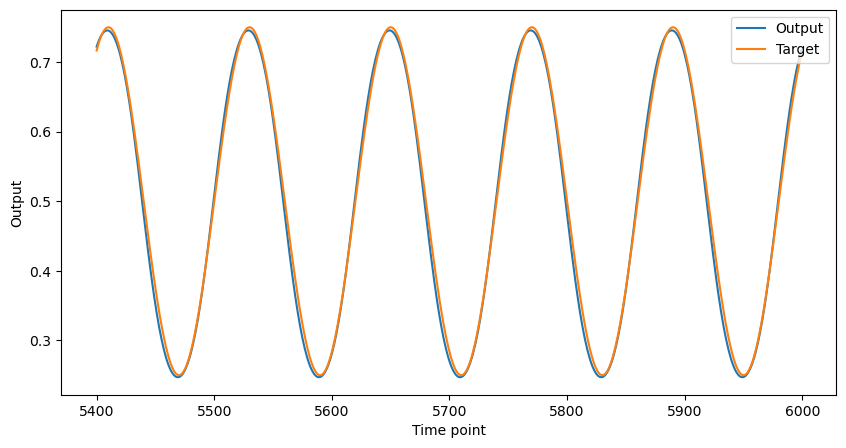

In [147]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[-600:], outputs_ff[-600:], label='Output')
plt.plot(time_points[-600:], targets[-600:], label='Target')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_phase_output.png")

In [148]:
target_peak = np.argmax(targets[500:620])
np.argmax(outputs_ff[500:620]) - target_peak

-1